In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from math import sqrt

In [11]:

class FOM(torch.optim.Optimizer):

    def __init__(self, params,hm_generator):
        super(FOM, self).__init__(params, {})
        self.gen=hm_generator

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        m,h,_=next(self.gen)
        m=m-1
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is not None:


                    state = self.state[p]
                    buf=state.get('momentum_buffer',None)
                    
                    dp=p.grad.mul(h)
                    if buf is not None:
                        dp.add_(buf,alpha=m)
                    state['momentum_buffer']=dp
                    p.add_(dp)

        return loss

def gd_gen(lr=1e-4,m=0):
    while True:
        yield m+1,-lr,None



In [18]:
class GoodModel(nn.Module):
    def __init__(self,h,d_in,d_out):
        super(GoodModel,self).__init__()
        self.fc1=nn.Linear(d_in,h,False)
        self.fc2=nn.Linear(h,d_out,False)

        nn.init.orthogonal_(self.fc1.weight,gain=sqrt(1))
        nn.init.orthogonal_(self.fc2.weight,gain=sqrt(1))
    def forward(self,x):
        return self.fc2(self.fc1(x))
    


In [9]:
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision
from optim import *

d=28*28
n=d
h=d


dataset=torch.utils.data.Subset(MNIST('data',download=True,transform=torchvision.transforms.ToTensor()),range(1,n+1))
dl=torch.utils.data.DataLoader(dataset,batch_size=d,shuffle=True,)
x,y=next(iter(dl))
#x,y=x.cuda(),y.cuda()
x=x.view(x.shape[0],-1)

In [16]:

log1=[]
log2=[]
log3=[]
jacobi=residual_wrapgen(shift_wrapgen(jacobi_basegen(1/2,5/2),1e-5,-1))
for gen,log in zip([gd_gen(1e-2,0.3),gd_gen(1e-2,0),jacobi],[log1,log2,log3]):
    

    #model=nn.Sequential(nn.Linear(d,h),nn.Linear(h,10))
    model=GoodModel(h,d,10)
    optim=FOM(model.parameters(),gen)
    #optim=torch.optim.SGD(model.parameters(),lr=1e-2,momentum=0.7)
    for epoch in range(200):
        logits=model(x)
        loss=nn.functional.l2(logits,y)
        loss.backward()
        log.append(loss.item())
        optim.step()



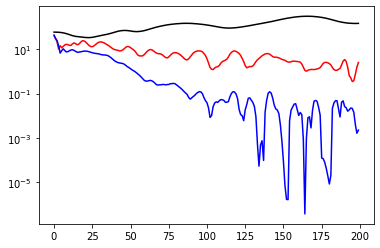

In [17]:
plt.plot(log1,c='r')
plt.plot(log2,c='b')
plt.plot(log3,c='k')
plt.yscale('log')